## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sys
import os
import gc
import sqlite3
from sqlalchemy import create_engine
import datetime as dt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import time
import re
import distance
from tqdm import tqdm
import subprocess
from os import path
from PIL import Image
from collections import Counter
import plotly.graph_objs as go


import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS

from bs4 import BeautifulSoup

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve

from mlxtend.classifier import StackingClassifier
from scipy.sparse import hstack

import spacy
nlp = spacy.load("en_core_web_sm")

## Loading Data

In [2]:
df = pd.read_csv("train.csv")
print(f"Size of dataset: {df.shape[0]}")

Size of dataset: 404290


## Exploratory Data Analysis

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
df.groupby('is_duplicate').count()['id']

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

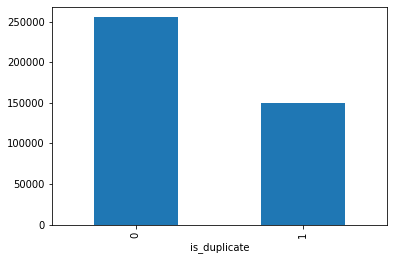

In [6]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [7]:
df['is_duplicate'].mean()

0.369197853026293

In [8]:
print(f"Percentage of non duplicate questions: {(1 - round(df['is_duplicate'].mean(), 2))*100}%")
print(f"Percentage of duplicate questions: {(round(df['is_duplicate'].mean(), 2))*100}%")

Percentage of non duplicate questions: 63.0%
Percentage of duplicate questions: 37.0%


In [9]:
u_qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

In [10]:
u_qids.nunique()

537933

In [11]:
u_qids.value_counts()

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64

In [12]:
df[((df['qid2'] == 4044) | (df['qid1'] == 4044)) & (df['is_duplicate'] == 1)]

,id,qid1,qid2,question1,question2,is_duplicate
6665,6665,13049,4044,How do I lose body fat quickly?,How can I lose weight quickly?,1
11993,11993,4044,20607,How can I lose weight quickly?,How can someone lose weight quickly?,1
26599,26599,11091,4044,What is the fastest way to lose weight safely?,How can I lose weight quickly?,1
46698,46698,4044,83500,How can I lose weight quickly?,Whats the most effective way/ solution to lose...,1
48476,48476,19500,4044,How can you rapidly lose weight in 14days?,How can I lose weight quickly?,1
98191,98191,9827,4044,How do I lose weight fast?,How can I lose weight quickly?,1
104913,104913,4044,11092,How can I lose weight quickly?,How do I lose weight in a short time?,1
127067,127067,24861,4044,How can I lose weight ?,How can I lose weight quickly?,1
127343,127343,4044,48082,How can I lose weight quickly?,How can I lose my weight fast?,1
133228,133228,25820,4044,How can you lose weight quickly?,How can I lose weight quickly?,1


In [13]:
df[((df['qid2'] == 30782) | (df['qid1'] == 30782)) & (df['is_duplicate'] == 1)]

,id,qid1,qid2,question1,question2,is_duplicate


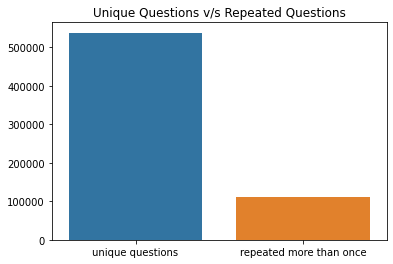

In [14]:
morethanonce = np.sum(u_qids.value_counts() > 1)
x = ['unique questions', 'repeated more than once']
y = [u_qids.nunique(), morethanonce]
plt.title('Unique Questions v/s Repeated Questions')
sns.barplot(x, y)

In [15]:
repeated_pairs = df.groupby(['qid1','qid2']).count().reset_index()

In [16]:
repeated_pairs

,qid1,qid2,id,question1,question2,is_duplicate
0,1,2,1,1,1,1
1,3,4,1,1,1,1
2,3,282170,1,1,1,1
3,3,380197,1,1,1,1
4,3,488853,1,1,1,1
...,...,...,...,...,...,...
404285,537924,537925,1,1,1,1
404286,537926,537927,1,1,1,1
404287,537928,537929,1,1,1,1
404288,537930,537931,1,1,1,1


In [17]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


In [18]:
pair_duplicates

,qid1,qid2,is_duplicate
0,1,2,1
1,3,4,1
2,3,282170,1
3,3,380197,1
4,3,488853,1
...,...,...,...
404285,537924,537925,1
404286,537926,537927,1
404287,537928,537929,1
404288,537930,537931,1


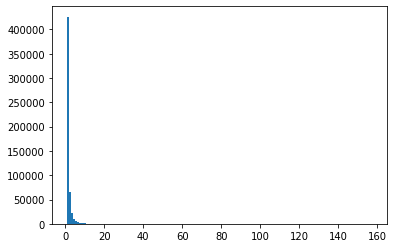

In [19]:
plt.hist(u_qids.value_counts(), bins=160);

In [20]:
u_qids.value_counts()

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64

In [21]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


## Basic Feature Engineering

In [22]:
df = df.fillna('')

In [23]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [24]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')

In [25]:
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

In [26]:
df['q1len'] = df['question1'].str.len()

In [27]:
df['q2len'] = df['question2'].str.len()

In [28]:
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))

In [29]:
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [30]:
def get_common_word_count(row):
    q1w = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2w = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(q1w & q2w)

In [31]:
df['word_common'] = df.apply(get_common_word_count, axis = 1)

In [32]:
def total_word_count(row):
    q1w = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2w = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(q1w) + len(q2w)

In [33]:
df['word_total'] = df.apply(total_word_count, axis = 1)

In [34]:
def word_share(row):
    q1w = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2w = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(q1w & q2w)/(len(q1w) + len(q2w))

In [35]:
df['word_share'] = df.apply(word_share, axis = 1)

In [36]:
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [37]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [38]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


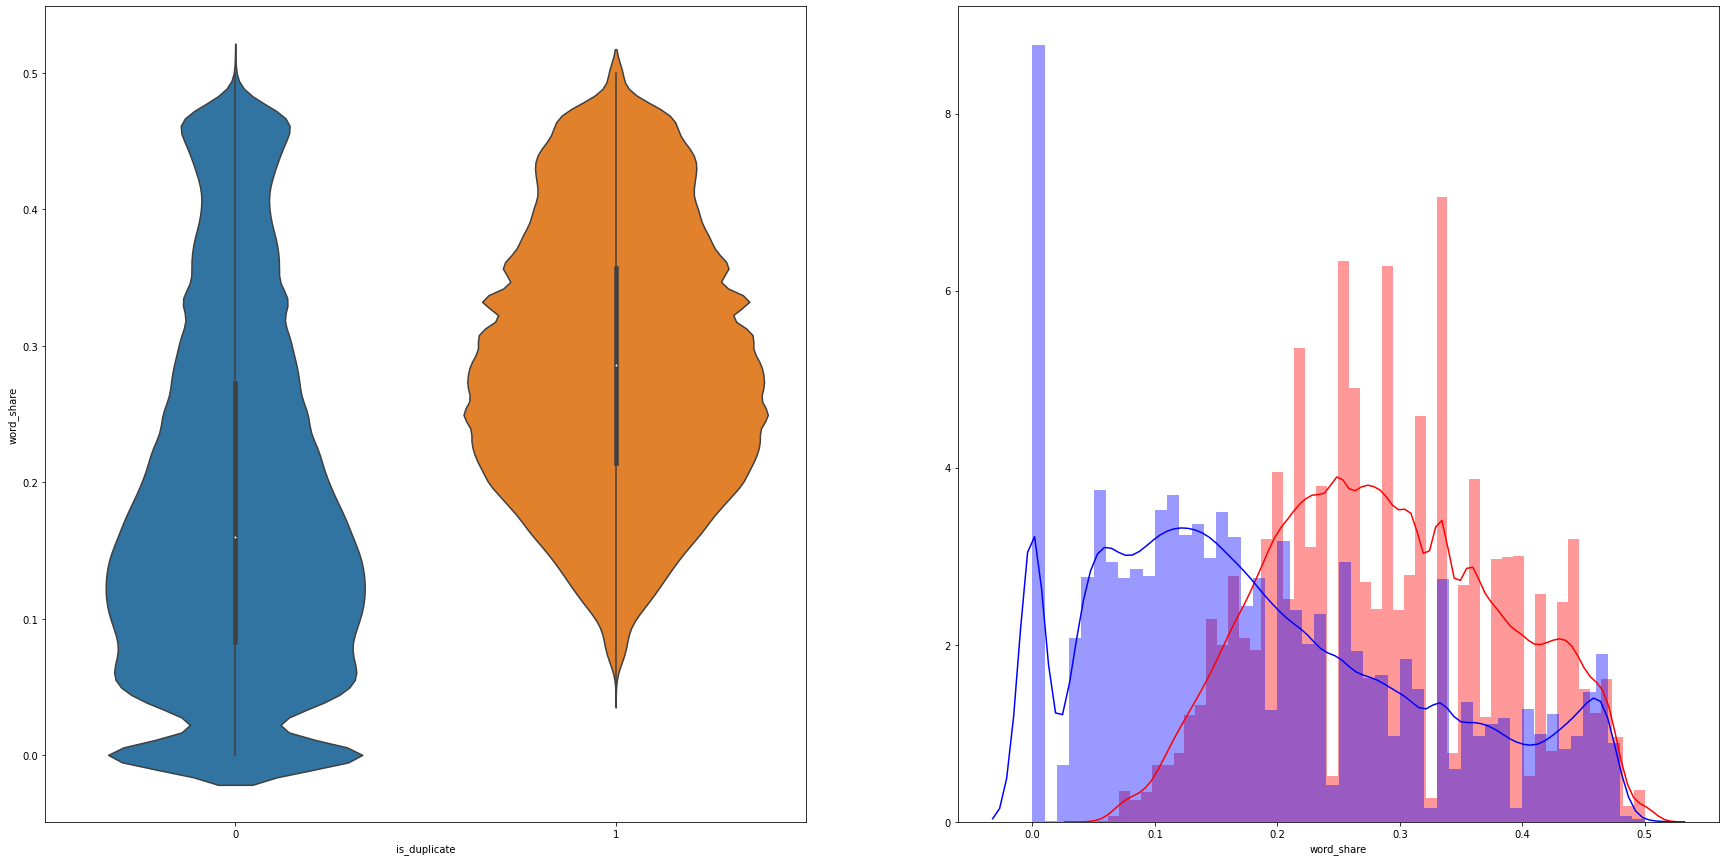

In [39]:
plt.figure(figsize=(30,15))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y='word_share', data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1]['word_share'], label = '1', color = 'red')
sns.distplot(df[df['is_duplicate'] == 0]['word_share'], label = '2', color = 'blue')

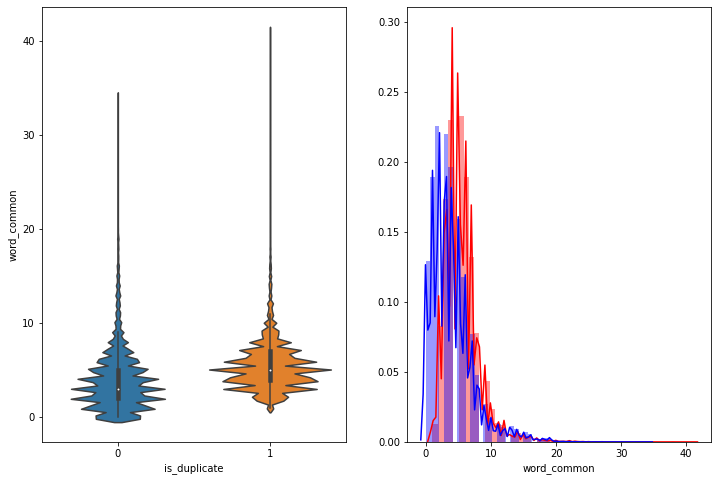

In [40]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [41]:
df.corr()

,id,qid1,qid2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
id,1.000000,0.629373,0.641993,-0.008784,-0.002686,-0.001308,0.003901,0.001620,0.003560,0.001131,-0.000014,0.003099,-0.002292,-0.002193,0.000252
qid1,0.629373,1.000000,0.700140,-0.247072,-0.383712,-0.235651,0.054494,0.026781,0.043720,0.023785,-0.088050,0.037325,-0.107337,-0.345627,-0.211861
qid2,0.641993,0.700140,1.000000,-0.260101,-0.310959,-0.345283,0.050025,0.065495,0.041854,0.062887,-0.084594,0.061109,-0.112508,-0.382395,-0.271850
is_duplicate,-0.008784,-0.247072,-0.260101,1.000000,0.339718,0.234760,-0.171079,-0.161969,-0.154320,-0.160445,0.232289,-0.183264,0.385486,0.323320,0.127099
freq_qid1,-0.002686,-0.383712,-0.310959,0.339718,1.000000,0.484144,-0.031979,-0.010354,-0.021064,-0.009126,0.098958,-0.013337,0.096194,0.814568,0.438490
freq_qid2,-0.001308,-0.235651,-0.345283,0.234760,0.484144,1.000000,-0.015635,-0.033177,-0.008158,-0.034834,0.068583,-0.022518,0.062568,0.901921,0.827815
q1len,0.003901,0.054494,0.050025,-0.171079,-0.031979,-0.015635,1.000000,0.484568,0.958003,0.458559,0.312436,0.807141,-0.163481,-0.026150,-0.008632
q2len,0.001620,0.026781,0.065495,-0.161969,-0.010354,-0.033177,0.484568,1.000000,0.461712,0.967470,0.311281,0.841717,-0.156076,-0.027105,-0.011979
q1_n_words,0.003560,0.043720,0.041854,-0.154320,-0.021064,-0.008158,0.958003,0.461712,1.000000,0.471247,0.328411,0.832359,-0.155392,-0.015806,-0.000267
q2_n_words,0.001131,0.023785,0.062887,-0.160445,-0.009126,-0.034834,0.458559,0.967470,0.471247,1.000000,0.309454,0.860794,-0.161765,-0.027598,-0.013654


## Text Features using fuzzywuzzy

In [42]:
SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words('english')

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                       .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                       .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                       .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                       .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                       .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                       .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
        
    return x

In [43]:
from array import array


def lcsubstrings(seq1, seq2, positions=False):
	"""Find the longest common substring(s) in the sequences `seq1` and `seq2`.
	
	If positions evaluates to `True` only their positions will be returned,
	together with their length, in a tuple:
	
		(length, [(start pos in seq1, start pos in seq2)..])
	
	Otherwise, the substrings themselves will be returned, in a set.
	
	Example:
	
		>>> lcsubstrings("sedentar", "dentist")
		{'dent'}
		>>> lcsubstrings("sedentar", "dentist", positions=True)
		(4, [(2, 0)])
	"""
	L1, L2 = len(seq1), len(seq2)
	ms = []
	mlen = last = 0
	if L1 < L2:
		seq1, seq2 = seq2, seq1
		L1, L2 = L2, L1
	
	column = array('L', range(L2))
	
	for i in range(L1):
		for j in range(L2):
			old = column[j]
			if seq1[i] == seq2[j]:
				if i == 0 or j == 0:
					column[j] = 1
				else:
					column[j] = last + 1
				if column[j] > mlen:
					mlen = column[j]
					ms = [(i, j)]
				elif column[j] == mlen:
					ms.append((i, j))
			else:
				column[j] = 0
			last = old
	
	if positions:
		return (mlen, tuple((i - mlen + 1, j - mlen + 1) for i, j in ms if ms))
	return set(seq1[i - mlen + 1:i + 1] for i, _ in ms if ms)

In [44]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [45]:
print("Extracting features for train:")
df = pd.read_csv("train.csv")
df = extract_features(df)
df.to_csv("nlp_features_train.csv", index=False)

df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [46]:
df = pd.read_csv('nlp_features_train.csv')
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [47]:
df_duplicate = df[df['is_duplicate']==1]
df_nonduplicate = df[df['is_duplicate']==0]

In [48]:
df_duplicate.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
5,5,11,12,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...,1,0.666656,0.571420,0.888879,0.799992,...,0.705878,1.0,0.0,0.0,17.0,81,77,73,73,0.160920
7,7,15,16,how can i be a good geologist,what should i do to be a great geologist,1,0.499975,0.499975,0.599988,0.428565,...,0.444440,1.0,0.0,2.0,8.0,71,61,61,67,0.354839


In [49]:
p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
n = np.dstack([df_nonduplicate['question1'], df_nonduplicate['question2']]).flatten()

In [50]:
print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s', encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s', encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [51]:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'), encoding='utf-8').read()
textn_w = open(path.join(d, 'train_n.txt'), encoding='utf-8').read()

In [52]:
stopwords = set(STOPWORDS)
stopwords.add('said')
stopwords.add('br')
stopwords.add(' ')
stopwords.remove('not')
stopwords.remove('no')
stopwords.remove('like')
print(f"Total number of words in duplicate pair questions: {len(textp_w)}")
print(f"Total number of words in non duplicate pair questions: {len(textn_w)}")

Total number of words in duplicate pair questions: 16110077
Total number of words in non duplicate pair questions: 33193612


Word Cloud for duplicate question pairs


(-0.5, 399.5, 199.5, -0.5)

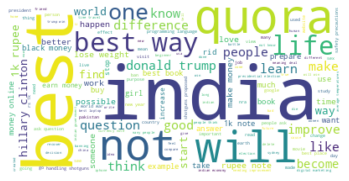

In [53]:
wc = WordCloud(background_color = 'white', max_words = len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print('Word Cloud for duplicate question pairs')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

Word Cloud for non duplicate question pairs


(-0.5, 399.5, 199.5, -0.5)

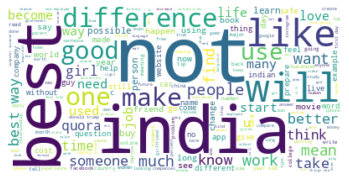

In [54]:
wc = WordCloud(background_color = 'white', max_words = len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print('Word Cloud for non duplicate question pairs')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

In [ ]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

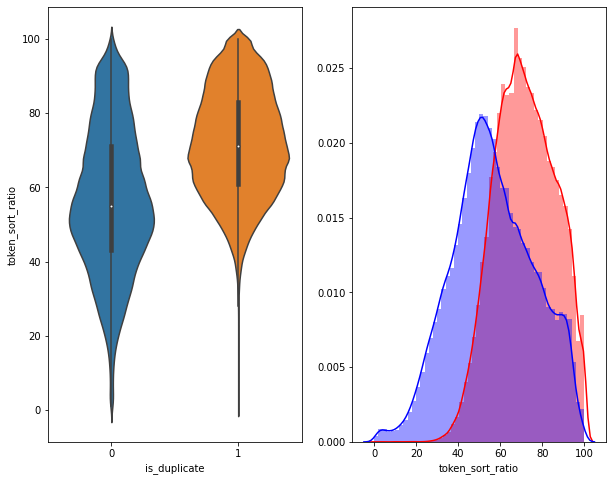

In [55]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

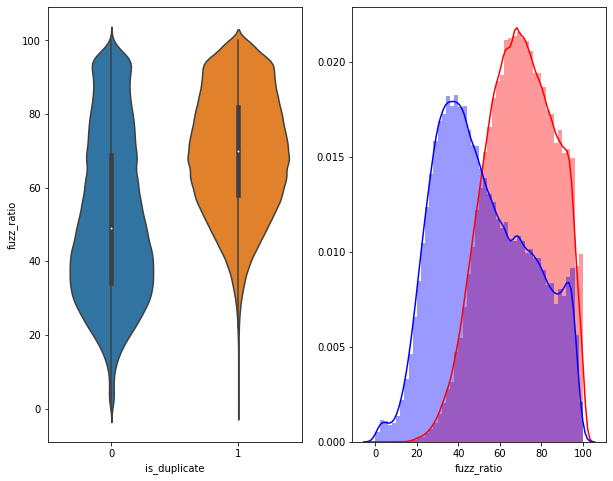

In [56]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [57]:
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [58]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.098s...
[t-SNE] Computed neighbors for 5000 samples in 0.542s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.131928
[t-SNE] Computed conditional probabilities in 0.732s
[t-SNE] Iteration 50: error = 81.3535919, gradient norm = 0.0532696 (50 iterations in 0.988s)
[t-SNE] Iteration 100: error = 70.6860962, gradient norm = 0.0106284 (50 iterations in 0.699s)
[t-SNE] Iteration 150: error = 69.0275650, gradient norm = 0.0053264 (50 iterations in 0.751s)
[t-SNE] Iteration 200: error = 68.2513199, gradient norm = 0.0047586 (50 iterations in 0.836s)
[t-SNE] Iteration 250: error = 67.7726898, gradient norm = 0.0034672

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [59]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.025s...
[t-SNE] Computed neighbors for 5000 samples in 0.691s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.131928
[t-SNE] Computed conditional probabilities in 0.346s
[t-SNE] Iteration 50: error = 80.5688934, gradient norm = 0.0322042 (50 iterations in 2.059s)
[t-SNE] Iteration 100: error = 69.4817276, gradient norm = 0.0036664 (50 iterations in 1.159s)
[t-SNE] Iteration 150: error = 68.1104889, gradient norm = 0.0017189 (50 iterations in 1.064s)
[t-SNE] Iteration 200: error = 67.5359879, gradient norm = 0.0014277 (50 iterations in 1.099s)
[t-SNE] Iteration 250: error = 67.2216873, gradient norm = 0.0010080

In [73]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

## Vectorizing Text Data with TFIDF Weighted Word Vectors(Glove)

In [74]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:

questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [ ]:
nlp = spacy.load('en_core_web_sm')

vecs1 = []
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        vec1 = word1.vector
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [2:13:51<00:00, 50.34it/s]


In [ ]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec1 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        vec2 = word2.vector
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:47:52<00:00, 62.46it/s]


In [ ]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)

if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [ ]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [ ]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,121.929927,100.083900,72.497894,115.641800,-48.370870,34.619058,-172.057787,-92.502617,113.223315,50.562441,...,12.397642,40.909519,8.150261,-15.170692,18.007709,6.166999,-30.124163,3.700902,-1.757693,-1.818058
1,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.013510,-39.140730,-82.692352,45.161489,-9.556289,...,-21.987077,-12.389279,20.667979,2.202714,-17.142454,-5.880972,-10.123963,-4.890663,-13.018389,-5.219310
2,-5.355015,73.671810,14.376365,104.130241,1.433537,35.229116,-148.519385,-97.124595,41.972195,50.948731,...,3.027700,14.025767,-2.960312,-3.206544,4.355141,2.936152,-20.199555,9.816351,11.894366,-8.798819
3,5.778359,-34.712038,48.999631,59.699204,40.661263,-41.658731,-36.808594,24.170655,0.235600,-29.407290,...,13.100007,1.405670,-1.891076,-7.882638,18.000561,12.106918,-10.507835,5.243834,10.158340,5.886351
4,51.138220,38.587312,123.639488,53.333041,-47.062739,37.356212,-298.722753,-106.421119,106.248914,65.880707,...,13.906532,43.461721,11.519207,-22.468284,45.431128,8.161224,-35.373910,7.728865,9.592849,5.447336


In [ ]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,125.983301,95.636485,42.114702,95.449980,-37.386295,39.400078,-148.116070,-87.851475,110.371966,62.272814,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,-106.871904,80.290331,79.066297,59.302092,-42.175328,117.616655,-144.364237,-127.131513,22.962533,25.397575,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,7.072875,15.513378,1.846914,85.937583,-33.808811,94.702337,-122.256856,-114.009530,53.922293,60.131814,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,39.421531,44.136989,-24.010929,85.265863,-0.339022,-9.323137,-60.499651,-37.044763,49.407848,-23.350150,...,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,31.950101,62.854106,1.778164,36.218768,-45.130875,66.674880,-106.342341,-22.901008,59.835938,62.663961,...,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


In [ ]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 384
Number of features in question2 w2v  dataframe : 384
Number of features in final dataframe  : 794


In [ ]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [ ]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [ ]:
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [ ]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [ ]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [ ]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [ ]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.199996000079998,0.166663888935184,0.0,0.0,0.14285510206997,0.0999990000099999,0.0,0.0,3.0,8.5,...,-0.452613651752472,15.652570605278,6.08213365077972,-11.8397651314735,13.1632919311523,-2.98961134254932,-22.7671056985855,-0.55659094452858,16.7820047736168,20.3098403215408
2,0.399992000159997,0.399992000159997,0.499987500312492,0.499987500312492,0.444439506227709,0.444439506227709,0.0,0.0,0.0,9.0,...,-7.29706252366304,8.17464561760426,11.8678730130196,-0.180742904543877,-7.7285645082593,-1.18125408887863,-10.2087883651257,1.95615618489683,5.9711550520733,-0.634018301963806
3,0.833319444675922,0.714275510349852,0.999983333611106,0.857130612419823,0.687495703151855,0.687495703151855,0.0,1.0,0.0,16.0,...,10.6274425089359,8.40339290164411,14.16905092448,-14.7492953687906,13.0176268517971,15.6888161092065,-26.4774019122124,24.7521114945412,14.29726113379,0.945210464298725
4,0.0,0.0,0.599988000239995,0.499991666805553,0.249997916684028,0.230767455634957,0.0,0.0,1.0,12.5,...,9.43481918051839,47.0162477493286,6.11483122035861,-9.12068559974432,-3.70159254875034,-6.60001696646214,-26.1024898421019,13.254497602582,10.0541534200311,-6.71233975887299
5,0.749981250468738,0.749981250468738,0.499987500312492,0.499987500312492,0.624992187597655,0.624992187597655,1.0,0.0,0.0,8.0,...,-0.158434137701988,13.7061135396361,6.35377380251884,-7.79693192709237,7.42785215843469,0.602214589715004,-17.1489275898784,-1.66515278816223,4.06413406133652,3.87387558817863


<h2> 4.2 Converting strings to numerics </h2>

In [ ]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
df = pd.DataFrame(np.array(data.values, dtype=np.float64), columns = cols)

In [ ]:
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 794)
Number of data points in test data : (30000, 794)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6324857142857143 Class 1:  0.36751428571428574
---------- Distribution of output variable in train data ----------
Class 0:  0.3675 Class 1:  0.3675


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.887242646958


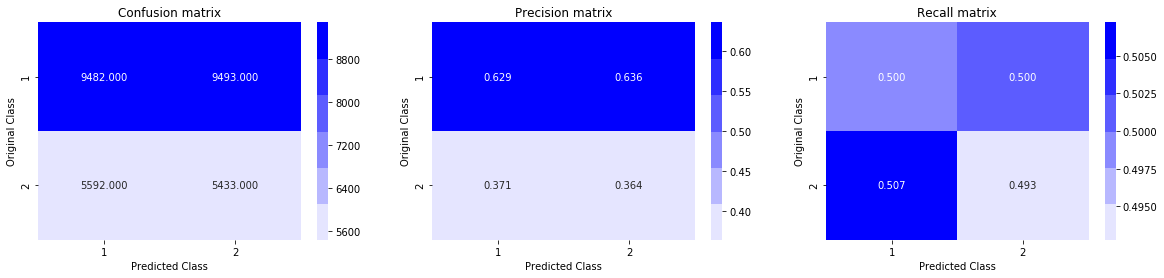

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.592800211149
For values of alpha =  0.0001 The log loss is: 0.532351700629
For values of alpha =  0.001 The log loss is: 0.527562275995
For values of alpha =  0.01 The log loss is: 0.534535408885
For values of alpha =  0.1 The log loss is: 0.525117052926
For values of alpha =  1 The log loss is: 0.520035530431
For values of alpha =  10 The log loss is: 0.521097925307


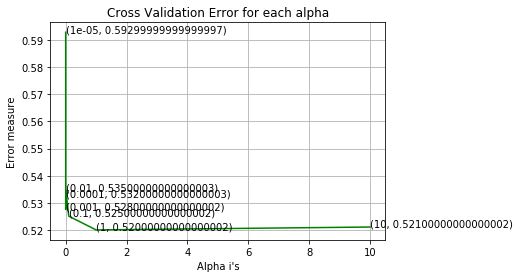

For values of best alpha =  1 The train log loss is: 0.513842874233
For values of best alpha =  1 The test log loss is: 0.520035530431
Total number of data points : 30000


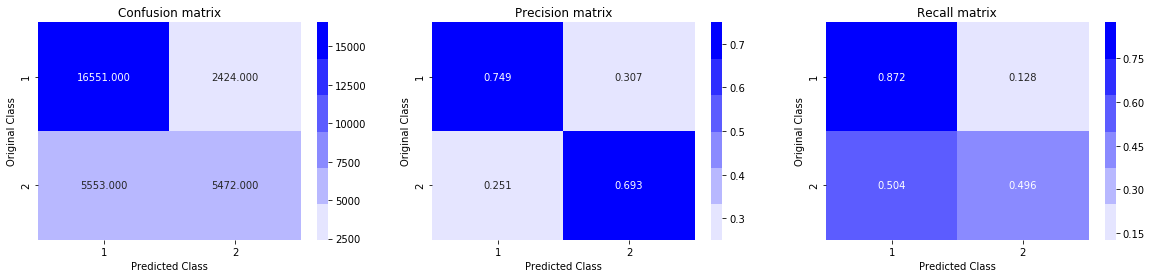

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.657611721261
For values of alpha =  0.0001 The log loss is: 0.489669093534
For values of alpha =  0.001 The log loss is: 0.521829068562
For values of alpha =  0.01 The log loss is: 0.566295616914
For values of alpha =  0.1 The log loss is: 0.599957866217
For values of alpha =  1 The log loss is: 0.635059427016
For values of alpha =  10 The log loss is: 0.654159467907


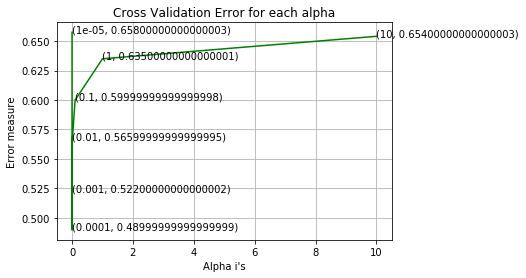

For values of best alpha =  0.0001 The train log loss is: 0.478054677285
For values of best alpha =  0.0001 The test log loss is: 0.489669093534
Total number of data points : 30000


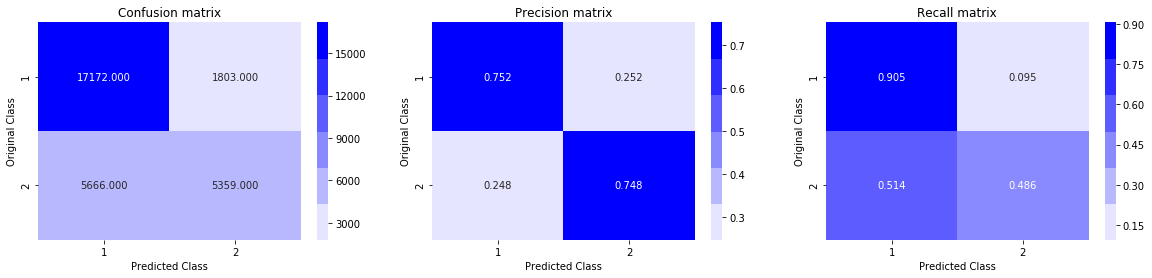

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684819	valid-logloss:0.684845
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61583	valid-logloss:0.616104
[20]	train-logloss:0.564616	valid-logloss:0.565273
[30]	train-logloss:0.525758	valid-logloss:0.52679
[40]	train-logloss:0.496661	valid-logloss:0.498021
[50]	train-logloss:0.473563	valid-logloss:0.475182
[60]	train-logloss:0.455315	valid-logloss:0.457186
[70]	train-logloss:0.440442	valid-logloss:0.442482
[80]	train-logloss:0.428424	valid-logloss:0.430795
[90]	train-logloss:0.418803	valid-logloss:0.421447
[100]	train-logloss:0.41069	valid-logloss:0.413583
[110]	train-logloss:0.403831	valid-logloss:0.40693
[120]	train-logloss:0.398076	valid-logloss:0.401402
[130]	train-logloss:0.393305	valid-logloss:0.396851
[140]	train-logloss:0.38913	valid-logloss:0.392952
[150]	train-logloss:0.385469	valid-logloss:0.389521
[160]	train-logloss:0.382327	vali

Total number of data points : 30000


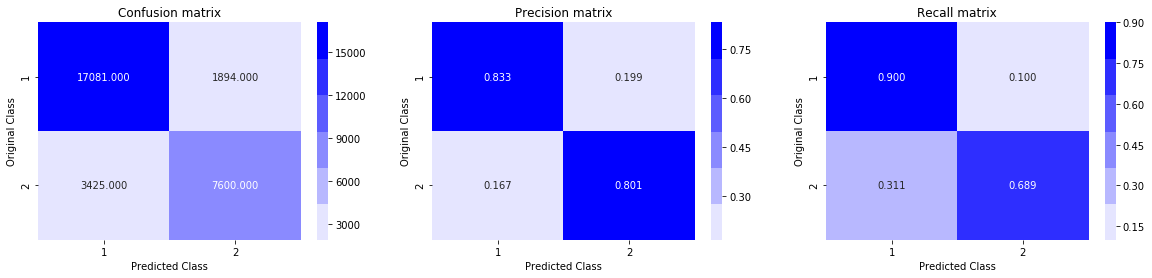

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)